In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**다양한 분류기 만드는 방법**

1) 같은 데이터 셋에 대해 각기 다른 훈련 알고리즘을 사용하는 방법

2) 데이터 셋의 서브셋을 무작위로 구정해서 같은 알고리즘을 각기 다르게 학습시키는 방법

#7.1 투표 기반 분류기

방법 1) 같은 데이터 셋에 대해 각기 다른 훈련 알고리즘을 사용하는 방법

###직접 투표

- 각기 다른 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 방법..
- **큰 수의 법칙**에 의해서 각 분류기가 약하더라도 충분히 많고 다양하다면 앙상블은 강해진다..

앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함..

In [2]:
#moons 데이터셋 준비

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import VotingClassifier   #투표기반 분류기
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC     #predict_proba() 함수 없음..

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

#3가지 분류기로 분류해서 젤 많이 예측된 클래스로 최종 예측
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'   #직접 투표
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [4]:
# 각 분류기 정확도 예측..

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))   #이름과 점수 출력

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**분석**

- 투표기반 분류기가 다른 개별 분류기보다 더 성능이 높다!!

###간접 투표

- 모든 분류기가 클래스의 확률을 예측할 수 있으면 가능..
- 개별 분류기의 예측을 평균내서 확률이 가장 높은 클래스를 예측한다..
- predict_proba() 메서드가 있어야 가능..

In [5]:
#SVC가 원래 없는데, probability 매개변수를 True로 두면 속도는 좀 느려도(교차검증) 가능하다..

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

#3가지 분류기로 분류해서 젤 많이 예측된 클래스로 최종 예측
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'   #간접 투표
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [6]:
#간접투표 정확도..

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.928


#7.2 배깅과 페이스팅

방법 2) 데이터 셋의 서브셋을 무작위로 구정해서 같은 알고리즘을 각기 다르게 학습시키는 방법



- 각 예측기마다 훈련에 사용할 샘플을 무작위로 골라야한다...
- 배깅 : **복원 추출**  /  페이스팅 : **비복원 추출**
- 둘 다 **한 예측기를 위한 샘플을 뽑을 때**를 이야기하는 것..
- 전반적으로는 배깅이 더 나은 모델을 만듦
- 이렇게 뽑아서 모든 예측기가 훈련을 다 하면 그 예측들을 다 모아서 사용한다
- 모으는 게 **수집 함수**이다
    - 분류일 때는 **통계적 최빈값**, 회귀일 때는 **평균**
- 각각의 예측기는 전체 훈련세트로 훈련한 거보다 크게 편향되어 있지만, 수집함수를 통과하면 편향, 분산 모두 감소한다

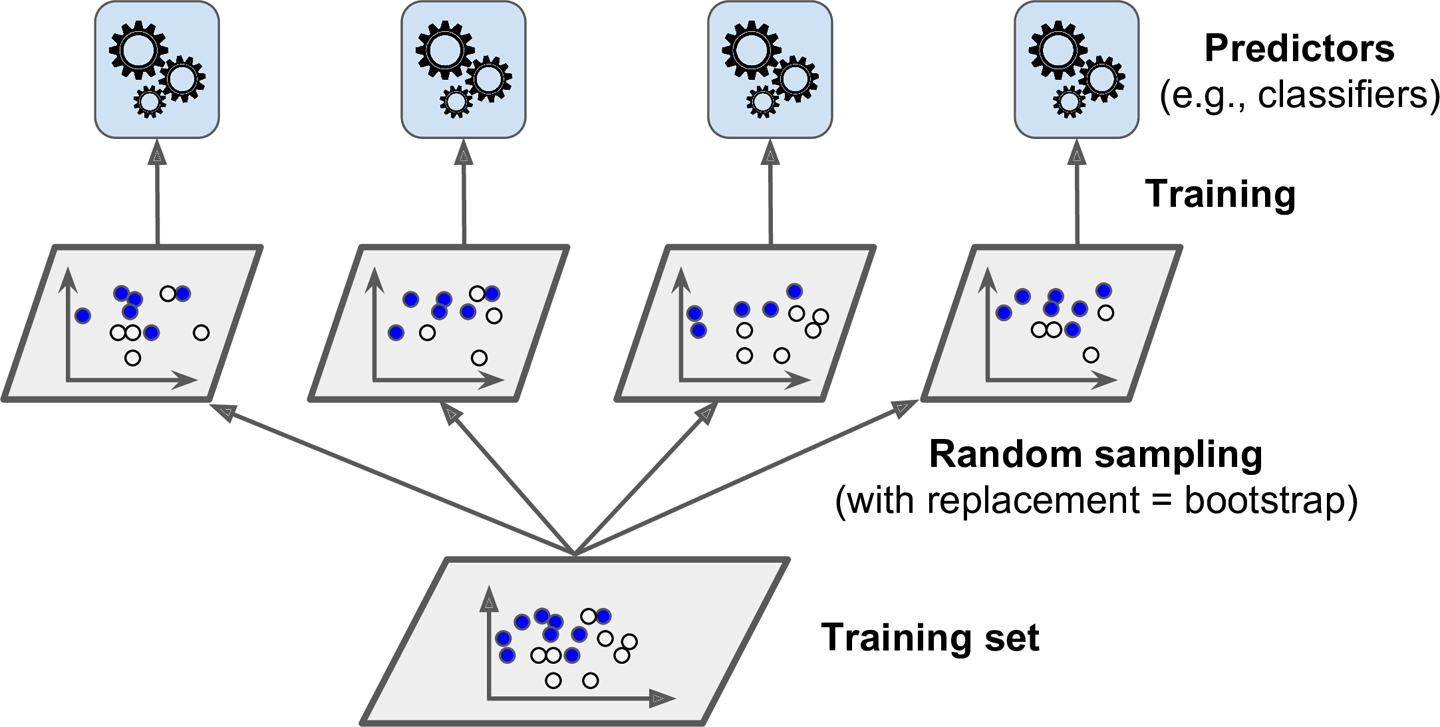

##7.2.1 사이킷런의 배깅과 페이스팅

**매개변수**

- n_estimators : 500개의 결정트리를 앙상블 하겠다
- max_samples : 100개의 샘플을 뽑아서 개별 분류기의 훈련에 사용하겠다
- bootstrap : True이면 배깅, False이면 페이스팅

In [7]:
#배깅 앙상블 구현

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
#그냥 결정트리 한개..

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [9]:
#점수 확인.. 앙상블이 더 높다!!

print(f"앙상블 시 점수는 {accuracy_score(y_test, y_pred)}입니다")
print(f"결정트리 하나의 점수는 {accuracy_score(y_test, y_pred_tree)}입니다")

앙상블 시 점수는 0.912입니다
결정트리 하나의 점수는 0.856입니다


In [10]:
#결정경계 그리는 함수..

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

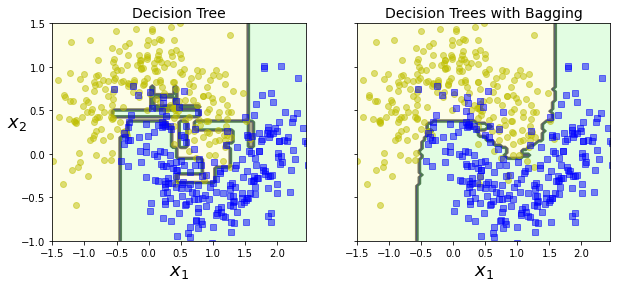

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

#결정트리 한개
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

#앙상블
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

**분석**

- 배깅을 사용한 오른쪽이 훨씬 일반화가 잘 됨
- 비슷한 편향(훈련 세트의 오차 수는 비슷)에서 더 작은 분산(결정경계가 덜 불규칙)을 만든다

##7.2.2 oob 평가

- 배깅 사용시 훈련에 사용되지 않는 샘플들을 **oob 샘플**이라고 함
- 평균적으로 $37\%$정도 남겨진다 (n_samples를 기본값으로 두었을 때..)
- **검증 세트 대용으로 oob 샘플 사용**
- oob_score매개변수를 True로 주면 자동으로 훈련 끝난 뒤 oob 평가를 수행함..

**어떤 샘플이 어떤 분류기의 oob샘플에 들어갈 확률**

- 전체 샘플 : $m$개
- 추출하고 싶은 훈련세트 수 : $n$개
- oob샘플에 들어갈 확률 : $(1-\dfrac{1}{m})^n$..
- 이게 기본값일 때는 $n = m$이다..
- 그럼 결국 $(1-\dfrac{1}{m})^m$이 되고, 이를 $m$을 무한대로 보내면 $37\%$에 가까워 진다..

In [12]:
#oob_score=True로 지정

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

#테스트 세트에서 약 90퍼센트 정확도 예측...

0.9013333333333333

In [13]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- oob 샘플에 대한 결정함수 값도 oob_decision_funciton_ 변수에서 확인 가능
     - predict_proba()메서드를 가지는 예측기이기 때문
     - 각 샘플이 oob샘플이 된 분류기 마다, 그 샘플의 예측결과를 확률로 나타낸다..
     - ex) 1, 0 이면 oob샘플이 된 분류기에서 모두 검증 결과 음성으로 나온 것이다..

In [14]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [15]:
#375개의 oob샘플들.. 2는 [음성, 양성]클래스

bag_clf.oob_decision_function_.shape

(375, 2)

#7.3 랜덤 패치와 랜덤 서브스페이스

- 특성도 랜덤으로 뽑는다..
- 각 예측기가 무작위로 선택한 입력특성의 일부분으로 훈련됨
- 이미지와 같은 고차원의 데이터셋을 다룰 때 유용함
- 특성 샘플링은 더 다양한 예측기를 만들고, 편향을 늘리지만 분산은 낮춘다

**랜덤 패치 방식**

- 특성과 샘플을 모두 샘플링하는 방식

**랜덤 서브스페이스 방식**
- 샘플을 다 쓰고 특성만 샘플링하는 방식

#7.4 랜덤 포레스트

- BaggingClassifier의 매개변수를 모두 가지고 있고, 결정트리의 성장을 제한할 수 있다
- 트리의 노드를 분할할 때 **선택한 특성 후보 중에서 최적의 특성을 찾음**
- 무작위성이 더 커짐..
    - 편향을 손해보지만, 분산을 낮춤..


In [16]:
#랜덤 포레스트 모델 이용..
#max_features매개변수의 기본값은 "auto"이고, "sqrt"와 같다..
#루트 특성개 만큼 중에서 최적의 특성을 찾아내겠다는 말이다

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [17]:
#배깅으로 만들어 봄..
#max_samples가 float형이면 비율을 나타냄..

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

In [18]:
# 두 방법(배깅, 랜덤포레스트)의 예측 비교.. 똑같다..

np.sum(y_pred_bag == y_pred_rf) / len(y_pred)

1.0

##7.4.1 엑스트라 트리

- 후보 특성을 사용해서 무작위로 분할한 다음 그중에서 최상의 분할을 선택함..
- 이런 극단적으로 무작위한 결정트리의 랜덤 포레스트를 **익스트림 랜덤 트리** 혹은 **엑스트라 트리**라고 함
- 이것 역시 편향은 늘어나지만 분산은 낮춤
- 일반적인 랜덤포레스트보다 훨씬 빠름

##7.4.2 특성 중요도

- 랜덤 포레스트는 상대적 특성 중요도를 알기 쉽다
- 어떤 특성을 사용한 노트가 평균적으로 불순도를 얼마나 감소시키는지를 확인해서 중요도를 측정한다
- 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산해서 중요도 전체 합이 1이 되도록 정규화한다..

In [19]:
#붓꽃 데이터 셋 특성 중요도 확인..

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


####MNIST 데이터셋의 각 픽셀의 중요도

In [20]:
#데이터 준비

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
#훈련

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [22]:
#이미지 하나 그리는 함수

def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

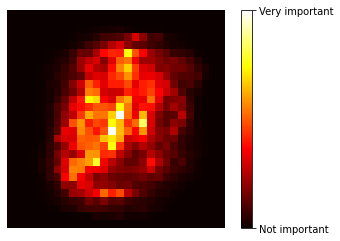

In [23]:
#특성 중요도를 그리자..
#중간픽셀이 중요하네..

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

#7.5 부스팅

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- **앞의 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것**
- 에이다 부스트 / 그레이디언트 부스팅이 있음
- 연속된 학습기법은 이전 예측기의 학습 및 평가 후에 다음 학습이 일어남 -> **병렬화 불가능**

##7.5.1 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높인다

**훈련 과정**

- 첫 번째 분류기를 훈련 세트로 훈련시키고 예측을 만듦
- 알고리즘이 **잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임**
- 두 번째 분류기는 업데이트된 가중치를 사용해서 다시 훈련하고 예측을 다시 만듦..
- 또 가중치를 조정함..
- 이를 반복..
- 아래 그림의 우하향 화살표가 가중치 업데이트하는 과정임


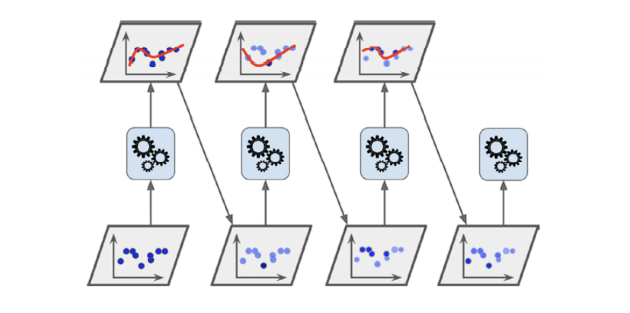

####수식 포함 설명

- $i$ : 샘플의 인덱스 ,  $j$ : 예측기 인덱스


#####1) $j$번째 예측기의 가중치가 적용된 에러율 계산

- 처음에는 $\dfrac{1}{m}$으로 초기화

- $ 
r_{j} = 
\dfrac{\sum\limits_{i=1 \atop \hat{y}_{j}^{(i)} \ne y^(i)}^{m}w^{(i)}}{\sum\limits_{i=1 }^{m}w^{(i)}}
$
-
여기에서 $\hat{y}_j^{(i)}$는 $i$번째 샘플에 대한 $j$번째 예측기의 예측
- 에러율이기 때문에 낮을수록 정확하다
- 범위 : 0 ~ 1

#####2) j번째 예측기의 가중치 계산

- $
\alpha_j = \eta * log\dfrac{1-r_j}{r_j}
$
- $\eta$는 학습률 매개변수
- 그래프를 그려보면 $r_j$(에러율)가 높아질수록 $\alpha_j$(가중치)는 **음수가 된다..**
- 에러율 0.5기준으로 가중치의 음/양이 바뀐다


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


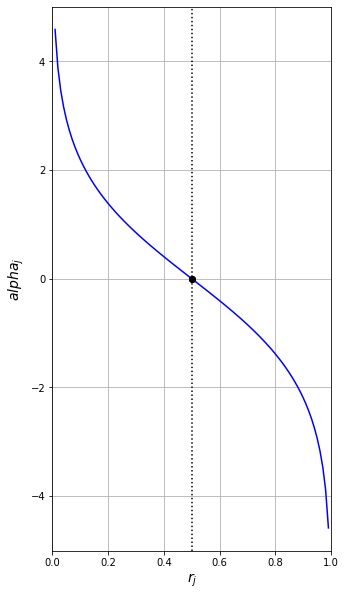

In [24]:
#예측기의 가중치 그래프


r_j = np.linspace(0, 1, 100)
alpha_j = np.log((1-r_j) / r_j)

plt.figure(figsize=(5, 10))
plt.plot(r_j, alpha_j, "b-")
plt.grid("on")
plt.plot([0.5, 0.5], [-5, 5], "k:")
plt.plot([0.5,0.5], [0, 0], "ko")
plt.axis([0, 1, -5, 5])
plt.xlabel("$r_j$", fontsize=14)
plt.ylabel("$alpha_j$", fontsize=14)
plt.show()

#####3) 가중치 업데이트

- 샘플의 가중치를 업데이트한다..
- 잘못 분류된 샘플의 가중치만 증가!
- $
w^{(i)} = 
\begin{cases}
    w^{(i)} & \hat{y}_j^{(i)} = y^{(i)} \text{일 때}\\
    w^{(i)}\exp(\alpha_j) & \hat{y}_j^{(i)} \ne y^{(i)} \text{일 때}
\end{cases}
$

- 여기에서 $i = 1, 2, 3,,,, m$ (샘플 수)

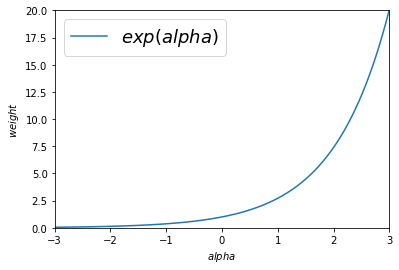

In [25]:
#지수함수..

x_5 = np.linspace(-3, 3, 100)
exp = np.exp(x_5)
plt.plot(x_5, exp, label="$exp(alpha)$")
plt.xlabel("$alpha$")
plt.ylabel("$weight$")
plt.axis([-3, 3, 0, 20])
plt.legend(loc="upper left", fontsize=18)
plt.show()

#####4) 마지막 정규화

- 모든 샘플의 가중치를 정규화한다
- 합쳐서 1이 되도록..
- 즉, 
$
\sum\limits_{i=1}^{m}w^{(i)}
$ 로 나눈다..

#####5) 예측

- 계속 업데이트해서 가다가 완벽한 예측기가 만들어지면 중지한다..
- 예측은 단순히 모든 예측기의 예측을 만든다
- 그 예측이 맞을 경우, 예측기 가중치 $\alpha_j$를 더해서 결과를 만듦
- 각 클래스마다 가중치 합이 생성되는데, 클래스별로 가중치 합이 가장 큰 클래스가 예측 결과가 된다..
- $
\hat{y}(\mathbf{x}) = $argmax
$\sum\limits_{i=1 \atop \hat{y}_{j}(\mathbf{x}) = k}^{N}\alpha_j$

**SAMME 클래스**

- 다중 클래스 버전이다
- predict_proba() 메서드가 있으면 클래스의 확률을 추정할 수 있다..
- 그러면 약간 변종은 **SAMME.R 클래스**를 사용한다
- 얘는 클래스 확률에 기반해서 계산한다..
- 일반적으로 SAMME.R이 더 좋다..

####에이다부스트 코딩으로 구현

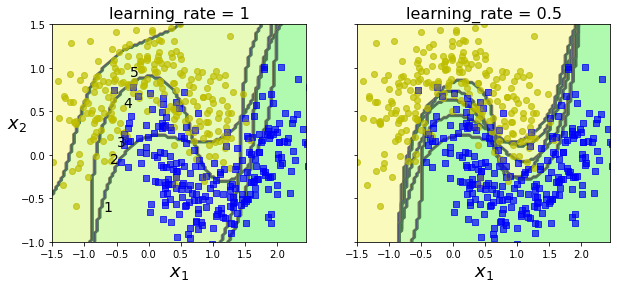

In [26]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    #가중치를 1/m으로 초기화
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    #5회 반복으로 예측기를 계속 추가해 나간다
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        #에러율 구하기
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        #가중치 구하기
        alpha = learning_rate * np.log((1 - r) / r)
        #가중치 업데이트
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        #다 더하면 1이 되도록 정규화
        sample_weights /= sample_weights.sum()
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

**분석**

- 점점 올바르게 분류해 나간다
- 각 예측기마다 가중치는 모두 다르다..(업데이트 되니까!!)

####에이다부스트의 기본 추정기

- 200개의 아주 얕은 **결정 트리**기반
- 얕다는 것은 max_depth=1 이라는 말이다
- 추정기(n_estimators) 수를 줄이거나 추정기의 규제를 조정해서 과대적합을 막을 수 있다

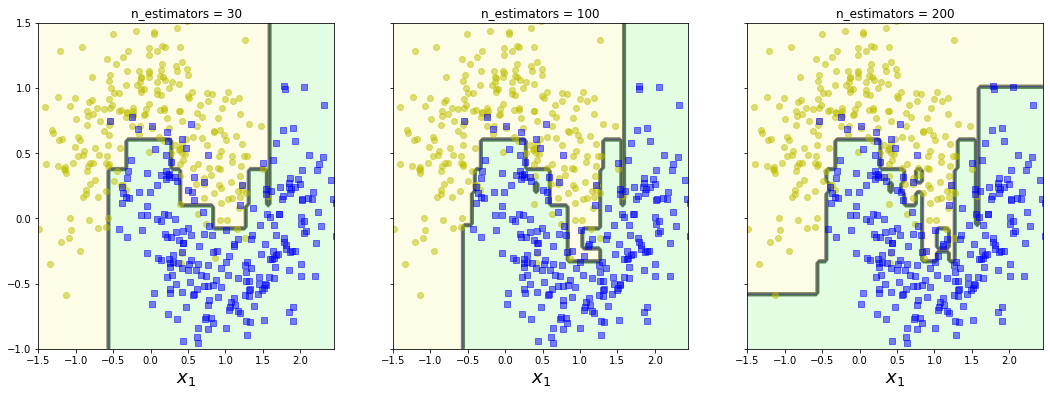

In [27]:
#AdaBoostClassifier의 기본 추정기..

from sklearn.ensemble import AdaBoostClassifier

fix, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)
for n_estimator, subplot in ((30,0), (100,1), (200,2)):
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1, ), n_estimators=n_estimator,
        algorithm="SAMME.R", learning_rate=0.5, random_state=42
    )
    ada_clf.fit(X_train, y_train)

    #결정경계 까지..
    plt.sca(axes[subplot])
    plot_decision_boundary(ada_clf, X, y)
    plt.title(f"n_estimators = {n_estimator}")
    if subplot == 1 or 2:
        plt.ylabel("")

**분석**

- 추정기 수가 많아질수록 과대적합된다

##7.5.2 그레이디언트 부스팅

이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킨다

###회귀문제 하나 풀자..

- **그레이디언트 부스티드 회귀 트리(GBRT)**
- $y = 3X^2 + 잡음$

####결정트리를 직접 만들어서 코딩..

In [28]:
#새로운 데이터 생성

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [29]:
from sklearn.tree import DecisionTreeRegressor

#첫번째 트리 훈련..
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [30]:
y2 = y - tree_reg1.predict(X)       #잔여오차 생성..
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)        #잔여오차에 다음 예측기 학습..

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [31]:
y3 = y2 - tree_reg2.predict(X)      #잔여오차 생성..
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)        #잔여오차에 다음 예측기 학습..

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

최종 예측은 앞선 모든 모델들로 예측하고, 다 더하면 된다!!

In [32]:
#새로운 샘플 하나.. 얘를 왜 0.8로 했지..??

X_new = np.array([[0.4]])

In [33]:
y_pred = np.sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [34]:
y_pred, 3*(0.4**2)

(array([0.49995198]), 0.4800000000000001)

In [35]:
#예측을 그리는 함수..

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    #예측기들마다 예측시킨걸 다 더해서 y_pred를 만든다
    #regressors 매개변수가 리스트일 것을 가정
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    #데이터를 찍고
    plt.plot(X[:, 0], y, data_style, label=data_label)
    #예측은 선으로 그린다..
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

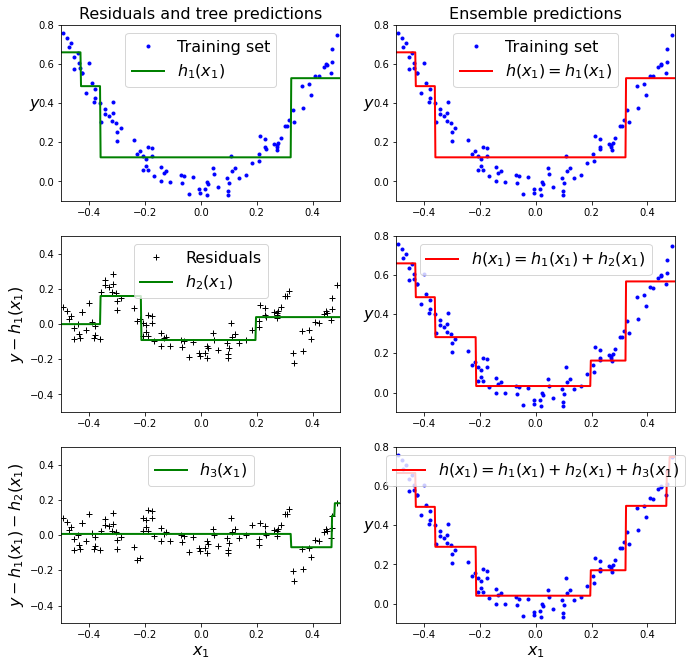

In [36]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

**분석**

- 왼쪽 열은 각 예측기의 그래프이다
- 오른쪽 열은 예측기의 예측을 더한 최종 예측이다
- 앙상블이 추가될수록 예측이 점차 좋아진다!!

####사이킷런의 GradientBoostingRegressor 사용

- subsample 매개변수 : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 정한다
    - 편향이 높아지는 대신 분산이 낮아진다..
    - 훈련 속도도 엄청 빠르다..
    - **확률적 그레이디언트 부스팅**이라고 한다..

---

- 결정트리 성장을 제어하는 매개변수 있음..
- learning_rate 매개변수 : 각 **트리의 기여정도를 조절..**
    - 학습률이 낮으면 많은 트리(예측기)가 필요하지만 성능은 좋다..
    - **축소**라는 규제방법이다

In [37]:
#위의 직접코딩이랑 같은 앙상블을 만듦..

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
#비교를 위한 모델.. 추정기를 많게함..

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200,
                                      learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

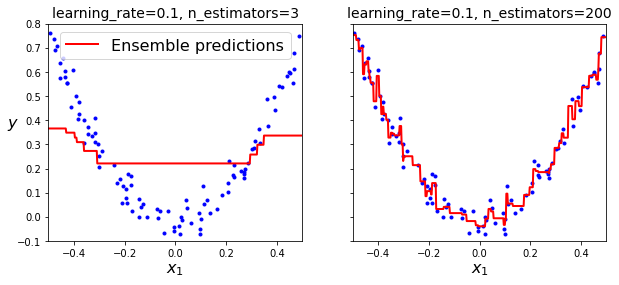

In [39]:
#그래프 그리기..

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
#3개의 결정트리 앙상블로 예측한 모델..
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
#200개의 결정트리 앙상블로 예측한 모델..
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**분석**

- **축소** 규제방법 사용
    - 학습률을 낮게 설정하고 충분한 트리를 앙상블하는 방법
- 왼쪽은 너무 트리가 부족하고, 오른쪽은 너무 많아서 과대적합된 모습이다
- 최적의 트리 수를 찾으려면 **조기 종료**를 사용할 수 있다..

####조기종료로 최적의 트리 수 찾기

#####방법 1) 최대 추정기 수 까지 모두 훈련하고 최저 검증오차일 때를 찾는다

- 최대 깊이가 2인 결정트리를 120개 앙상블 한다..
- 각 예측기(결정트리)를 훈련시키면서 검증오차를 측정해서 저장한다
- 측정 시 staged_predict() 메서드를 사용한다..

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

#각 훈련단계에서 검증오차 측정 후 저장..
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
#최고의 추정기 갯수..
best_n_estimators = np.argmin(errors) + 1

#최고의 추정기 갯수만큼 앙상블..
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

#그래프를 위해 최저 검증오차를 저장해놓는다
min_error = np.min(errors)

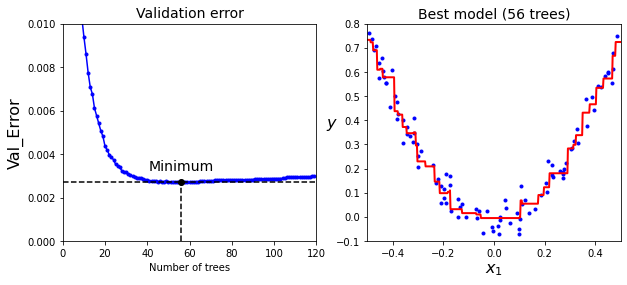

In [41]:
#그래프..

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Val_Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({best_n_estimators} trees)", fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**분석**

- 왼쪽 그림은 각 훈련마다의 검증에러를 추정기의 수에따라 나타낸 것이다
- 오른쪽은 최고의 추정기 수를 가지고 앙상블한 모델의 예측을 나타낸 것이다

#####방법 2) 찐 조기종료..

- 위에거는 다 하고 최적값을 찾는데 얘는 진짜 그만함..

- warm_start=True로 지정하면 이어서 훈련가능..

In [42]:
#warm_start=True로 지정
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
#참는 횟수..
error_going_up = 0
for n_estimators in range(1, 120):
    #점점 추정기 수를 늘려가면서 모델 훈련
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    #예측 후 검증오차 확인..
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    #작으면 최저오차 갱신
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    #아니면 참는 횟수 올리고 조기종료..
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [43]:
#얘는 61개가 최고래.. 그 때의 검증 오차..

print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

61
Minimum validation MSE: 0.002712853325235463


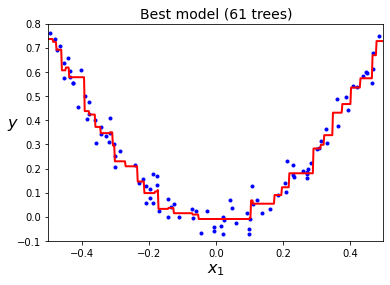

In [44]:
#이 앙상블의 예측도 그려보자..

plt.figure(figsize=(6,4))
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({gbrt.n_estimators} trees)", fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

####XGBoost 라이브러리 사용

- 패키지 목표 : 속도, 확장성, 이식성
- 조기종료같은 좋은 기능 제공
- 에러는 뜨는데 잘 되는건 같네..

In [45]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)

print("Validation MSE:", val_error)

[15:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [46]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)

print("Validation MSE:", val_error)

[15:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

#7.6 스태킹

**기본 아이디어**

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 예측을 취합하는 모델을 훈련시킬 수는 없을까?
- **블렌더** : 새로운 예측기 ( 앙상블을 수집하는 )

##학습 방법

- **홀드 아웃** 세트를 이용
- 훈련세트를 서브셋 1, 서브셋 2로 나눔
    - 레이어가 많다면 더 많이 나눔..
- 첫 번째 레이어의 예측기들을 서브셋 1로 훈련시킨다
- 첫 번째 레이어의 예측기로 서브셋 2를 예측한다
- 그 예측결과들로 마지막 **블렌더**를 훈련시킨다..
- 새로운 샘플이 들어와서 레이어들을 통과후 블렌더까지 통과하면 최종 예측이 나오는 것이다..

**훈련세트를 홀드아웃세트로 나눠서 서브셋1로 예측기들을 훈련**

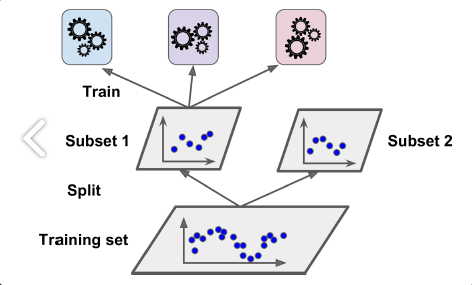

**서브셋 2로 예측을 만들어서 블렌더 훈련**

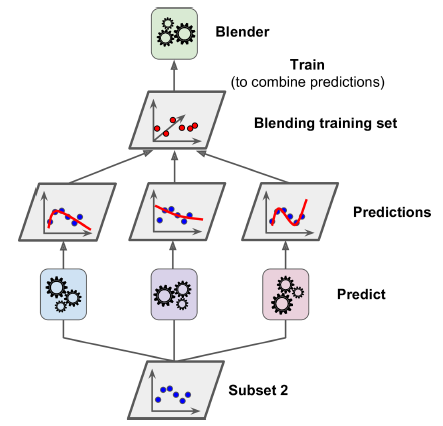

**새로운 샘플에 대한 예측**

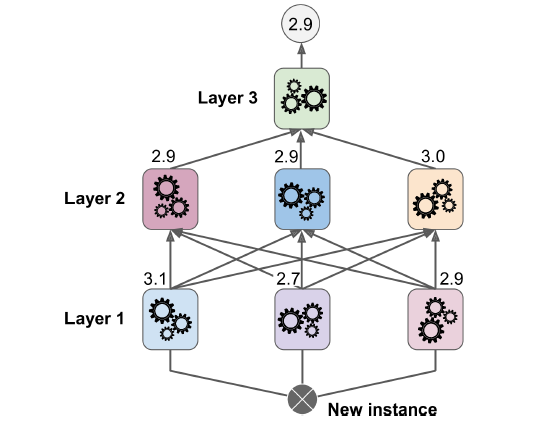

#7.7 연습문제